In [12]:
import pandas as pd
import numpy as np
import json
from scipy.spatial.distance import euclidean

# Load the dataset with error handling
file_path = r"C:\Users\shash\Desktop\channel_reinforcement_cue_neighbor.csv"

try:
    data = pd.read_csv(file_path, error_bad_lines=False, engine='python')
    print("Dataset loaded successfully")
except pd.errors.ParserError as e:
    print(f"Error loading dataset: {e}")
    data = pd.read_csv(file_path, error_bad_lines=False, engine='python')
    print("Dataset loaded with Python engine")

# Limit the dataset to the first 5000 rows for processing
data = data.head(10000)

print("Columns in the dataset:", data.columns)

# Helper function to extract position from JSON strings
def extract_position(json_str):
    try:
        pos_data = json.loads(json_str)
        pos = pos_data["action"]["pos"]
        return pos["tx"], pos["ty"]
    except (json.JSONDecodeError, KeyError):
        return np.nan, np.nan

# Initialize lists to store matrices
cue_distance_matrices = []
due_distance_matrices = []
mbs_distance_matrices = []

cue_channel_matrices = []
due_channel_matrices = []
mbs_channel_matrices = []

cue_rb_matrices = []
due_rb_matrices = []
mbs_rb_matrices = []

cue_actions_list = []
due_actions_list = []

cue_rewards_list = []
due_rewards_list = []

cue_states_list = []
due_states_list = []

cue_due_distance_matrices = []
cue_mbs_distance_matrices = []
due_due_distance_matrices = []

cue_due_channel_matrices = []
cue_mbs_channel_matrices = []
due_due_channel_matrices = []

# Process each row in the dataset
for idx in range(len(data)):
    row = data.iloc[idx]
    
    # Extract positions for CUE, DUE, and MBS
    cue_positions = []
    due_positions = []
    mbs_positions = []

    # Iterate over the columns to extract positions
    for col in data.columns:
        if 'cue' in col:
            tx, ty = extract_position(row[col])
            if not np.isnan(tx) and not np.isnan(ty):
                cue_positions.append((tx, ty))
        elif 'due' in col:
            tx, ty = extract_position(row[col])
            if not np.isnan(tx) and not np.isnan(ty):
                due_positions.append((tx, ty))
        elif 'mbs' in col:
            tx, ty = extract_position(row[col])
            if not np.isnan(tx) and not np.isnan(ty):
                mbs_positions.append((tx, ty))

    # Calculate distance matrix for CUE, DUE, and MBS
    def calculate_distance_matrix(positions):
        n = len(positions)
        distance_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                distance_matrix[i, j] = euclidean(positions[i], positions[j])
        return distance_matrix

    # Check if positions are not empty
    cue_distance_matrix = calculate_distance_matrix(cue_positions) if cue_positions else np.array([])
    due_distance_matrix = calculate_distance_matrix(due_positions) if due_positions else np.array([])
    mbs_distance_matrix = calculate_distance_matrix(mbs_positions) if mbs_positions else np.array([])

    # Channel matrix calculation using inverse distance squared model
    def calculate_channel_matrix(distance_matrix):
        if distance_matrix.size > 0:
            distance_matrix[distance_matrix == 0] = np.inf  # Avoid division by zero
            channel_matrix = 1 / (distance_matrix ** 2)
            return channel_matrix
        return np.array([])

    # Calculate channel matrices
    cue_channel_matrix = calculate_channel_matrix(cue_distance_matrix.copy())
    due_channel_matrix = calculate_channel_matrix(due_distance_matrix.copy())
    mbs_channel_matrix = calculate_channel_matrix(mbs_distance_matrix.copy())

    # RB matrix calculation using Shannon-Hartley theorem
    def calculate_rb_matrix(channel_matrix):
        if channel_matrix.size > 0:
            bandwidth = 1  # Assuming bandwidth of 1 Hz
            noise_power = 1  # Assuming noise power spectral density of 1
            rb_matrix = bandwidth * np.log2(1 + channel_matrix / noise_power)
            return rb_matrix
        return np.array([])

    # Calculate RB matrices
    cue_rb_matrix = calculate_rb_matrix(cue_channel_matrix)
    due_rb_matrix = calculate_rb_matrix(due_channel_matrix)
    mbs_rb_matrix = calculate_rb_matrix(mbs_channel_matrix)

    # Store matrices if they are not empty
    cue_distance_matrices.append(cue_distance_matrix.flatten() if cue_distance_matrix.size > 0 else np.nan)
    due_distance_matrices.append(due_distance_matrix.flatten() if due_distance_matrix.size > 0 else np.nan)
    mbs_distance_matrices.append(mbs_distance_matrix.flatten() if mbs_distance_matrix.size > 0 else np.nan)

    cue_channel_matrices.append(cue_channel_matrix.flatten() if cue_channel_matrix.size > 0 else np.nan)
    due_channel_matrices.append(due_channel_matrix.flatten() if due_channel_matrix.size > 0 else np.nan)
    mbs_channel_matrices.append(mbs_channel_matrix.flatten() if mbs_channel_matrix.size > 0 else np.nan)

    cue_rb_matrices.append(cue_rb_matrix.flatten() if cue_rb_matrix.size > 0 else np.nan)
    due_rb_matrices.append(due_rb_matrix.flatten() if due_rb_matrix.size > 0 else np.nan)
    mbs_rb_matrices.append(mbs_rb_matrix.flatten() if mbs_rb_matrix.size > 0 else np.nan)

    # Custom function to calculate other actions, rewards, and states
    def calculate_other_actions_rewards_states(distance_matrix, channel_matrix, rb_matrix):
        if distance_matrix.size > 0 and channel_matrix.size > 0 and rb_matrix.size > 0:
            other_actions = distance_matrix * channel_matrix  # Placeholder formula
            rewards = rb_matrix * distance_matrix  # Placeholder formula
            states = (distance_matrix + channel_matrix + rb_matrix) / 3  # Placeholder formula
            return other_actions, rewards, states
        return np.nan, np.nan, np.nan

    # Calculate other actions, rewards, and states for CUE and DUE
    cue_actions, cue_rewards, cue_states = calculate_other_actions_rewards_states(
        cue_distance_matrix, cue_channel_matrix, cue_rb_matrix
    )
    due_actions, due_rewards, due_states = calculate_other_actions_rewards_states(
        due_distance_matrix, due_channel_matrix, due_rb_matrix
    )

    # Store other actions, rewards, and states
    cue_actions_list.append(cue_actions.flatten() if cue_actions.size > 0 else np.nan)
    cue_rewards_list.append(cue_rewards.flatten() if cue_rewards.size > 0 else np.nan)
    cue_states_list.append(cue_states.flatten() if cue_states.size > 0 else np.nan)

    due_actions_list.append(due_actions.flatten() if due_actions.size > 0 else np.nan)
    due_rewards_list.append(due_rewards.flatten() if due_rewards.size > 0 else np.nan)
    due_states_list.append(due_states.flatten() if due_states.size > 0 else np.nan)

    # Calculate distances between DUE and CUE, and CUE and MBS for distances and channels
    def calculate_inter_distances(matrix1, matrix2):
        size1 = len(matrix1)
        size2 = len(matrix2)
        inter_distance_matrix = np.zeros((size1, size2))
        for i in range(size1):
            for j in range(size2):
                inter_distance_matrix[i, j] = euclidean(matrix1[i], matrix2[j])
        return inter_distance_matrix

    # Calculate inter-distances and channels
    cue_due_distance_matrix = calculate_inter_distances(list(cue_positions), list(due_positions)) if cue_positions and due_positions else np.array([])
    cue_mbs_distance_matrix = calculate_inter_distances(list(cue_positions), list(mbs_positions)) if cue_positions and mbs_positions else np.array([])
    due_due_distance_matrix = calculate_inter_distances(list(due_positions), list(due_positions)) if due_positions else np.array([])

    cue_due_channel_matrix = calculate_channel_matrix(cue_due_distance_matrix.copy())
    cue_mbs_channel_matrix = calculate_channel_matrix(cue_mbs_distance_matrix.copy())
    due_due_channel_matrix = calculate_channel_matrix(due_due_distance_matrix.copy())

    # Store inter-distances and channels
    cue_due_distance_matrices.append(cue_due_distance_matrix.flatten() if cue_due_distance_matrix.size > 0 else np.nan)
    cue_mbs_distance_matrices.append(cue_mbs_distance_matrix.flatten() if cue_mbs_distance_matrix.size > 0 else np.nan)
    due_due_distance_matrices.append(due_due_distance_matrix.flatten() if due_due_distance_matrix.size > 0 else np.nan)

    cue_due_channel_matrices.append(cue_due_channel_matrix.flatten() if cue_due_channel_matrix.size > 0 else np.nan)
    cue_mbs_channel_matrices.append(cue_mbs_channel_matrix.flatten() if cue_mbs_channel_matrix.size > 0 else np.nan)
    due_due_channel_matrices.append(due_due_channel_matrix.flatten() if due_due_channel_matrix.size > 0 else np.nan)

# Check the lengths of each list before creating the DataFrame
lengths = {
    'CUE_Distance': len(cue_distance_matrices),
    'DUE_Distance': len(due_distance_matrices),
    'MBS_Distance': len(mbs_distance_matrices),
    'CUE_Channel': len(cue_channel_matrices),
    'DUE_Channel': len(due_channel_matrices),
    'MBS_Channel': len(mbs_channel_matrices),
    'CUE_RB': len(cue_rb_matrices),
    'DUE_RB': len(due_rb_matrices),
    'MBS_RB': len(mbs_rb_matrices),
    'CUE_Actions': len(cue_actions_list),
    'DUE_Actions': len(due_actions_list),
    'CUE_Rewards': len(cue_rewards_list),
    'DUE_Rewards': len(due_rewards_list),
    'CUE_States': len(cue_states_list),
    'DUE_States': len(due_states_list),
    'CUE_DUE_Distance': len(cue_due_distance_matrices),
    'CUE_MBS_Distance': len(cue_mbs_distance_matrices),
    'DUE_DUE_Distance': len(due_due_distance_matrices),
    'CUE_DUE_Channel': len(cue_due_channel_matrices),
    'CUE_MBS_Channel': len(cue_mbs_channel_matrices),
    'DUE_DUE_Channel': len(due_due_channel_matrices),
}

print("Lengths of lists in metrics_dict:")
for key, value in lengths.items():
    print(f"{key}: {value}")

# Create a Pandas DataFrame for the metrics
metrics_dict = {
    'CUE_Distance': cue_distance_matrices,
    'DUE_Distance': due_distance_matrices,
    'MBS_Distance': mbs_distance_matrices,
    'CUE_Channel': cue_channel_matrices,
    'DUE_Channel': due_channel_matrices,
    'MBS_Channel': mbs_channel_matrices,
    'CUE_RB': cue_rb_matrices,
    'DUE_RB': due_rb_matrices,
    'MBS_RB': mbs_rb_matrices,
    'CUE_Actions': cue_actions_list,
    'DUE_Actions': due_actions_list,
    'CUE_Rewards': cue_rewards_list,
    'DUE_Rewards': due_rewards_list,
    'CUE_States': cue_states_list,
    'DUE_States': due_states_list,
    'CUE_DUE_Distance': cue_due_distance_matrices,
    'CUE_MBS_Distance': cue_mbs_distance_matrices,
    'DUE_DUE_Distance': due_due_distance_matrices,
    'CUE_DUE_Channel': cue_due_channel_matrices,
    'CUE_MBS_Channel': cue_mbs_channel_matrices,
    'DUE_DUE_Channel': due_due_channel_matrices,
}

# Create a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(metrics_dict)

# Save metrics to a CSV file
output_csv_path = r'C:\Users\shash\Desktop\processed_metrics3.csv'
metrics_df.to_csv(output_csv_path, index=False)
print("Metrics saved to CSV.")


C:\Users\shash\AppData\Local\Temp\ipykernel_18384\1828648861.py:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(file_path, error_bad_lines=False, engine='python')


Dataset loaded successfully
Columns in the dataset: Index(['cue00:mbs', 'cue01:mbs', 'cue02:mbs', 'cue03:mbs', 'cue04:mbs',
       'cue05:mbs', 'cue06:mbs', 'cue07:mbs', 'cue08:mbs', 'cue09:mbs',
       'cue10:mbs', 'cue11:mbs', 'cue12:mbs', 'cue13:mbs', 'cue14:mbs',
       'cue15:mbs', 'cue16:mbs', 'cue17:mbs', 'cue18:mbs', 'cue19:mbs',
       'cue20:mbs', 'cue21:mbs', 'cue22:mbs', 'cue23:mbs', 'cue24:mbs',
       'due00:due01', 'due02:due03', 'due04:due05', 'due06:due07',
       'due08:due09', 'due10:due11', 'due12:due13', 'due14:due15',
       'due16:due17', 'due18:due19', 'due20:due21', 'due22:due23',
       'due24:due25', 'due26:due27', 'due28:due29', 'due30:due31',
       'due32:due33', 'due34:due35', 'due36:due37', 'due38:due39',
       'due40:due41', 'due42:due43', 'due44:due45', 'due46:due47',
       'due48:due49'],
      dtype='object')
Metrics saved to CSV.


In [3]:
# Part 1: Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Notify the user that the CPU will be used
print("Using CPU for computation.")


Using CPU for computation.


In [4]:
import pandas as pd
import ast
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Path to the CSV file
dataset_path = r"C:\Users\shash\Desktop\processed_metrics3.csv"

# Load the CSV file in chunks
try:
    combined_data = []
    for chunk in pd.read_csv(dataset_path, chunksize=1000):
        combined_data.append(chunk)
    data = pd.concat(combined_data, ignore_index=True)
    print("Dataset loaded successfully")
except pd.errors.ParserError as e:
    print(f"Error loading dataset: {e}")
except MemoryError:
    print("Memory Error: The dataset might be too large to load into memory.")

# Clean the data if loaded successfully
if 'data' in locals():
    # Replace NaN values with 0
    data.fillna(0, inplace=True)

    # Function to safely evaluate the string representation of lists
    def safe_eval(val):
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            return []

    # Convert string representations of lists to actual lists
    for col in ['CUE_Distance', 'DUE_Distance', 'CUE_Channel', 'DUE_Channel', 'CUE_RB', 'DUE_RB']:
        data[col] = data[col].apply(safe_eval)  # Convert strings to lists

    # Flatten lists for normalization (mean of the list)
    for col in ['CUE_Distance', 'DUE_Distance', 'CUE_Channel', 'DUE_Channel', 'CUE_RB', 'DUE_RB']:
        data[col] = data[col].apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)  # Mean of the list

    # Set random values to NaN and 0 columns for critical metrics
    def set_random_values(series, lower_bound=1.0, upper_bound=100.0):
        return series.where(series != 0, np.random.uniform(lower_bound, upper_bound, size=len(series)))

    # Apply random value assignment to critical columns
    for col in ['CUE_Distance', 'DUE_Distance', 'CUE_Channel', 'DUE_Channel', 'CUE_RB', 'DUE_RB']:
        data[col] = set_random_values(data[col])

    # Convert relevant columns to appropriate data types
    dtype = {
        'CUE_Distance': 'float32', 
        'DUE_Distance': 'float32',
        'CUE_Channel': 'float32',
        'DUE_Channel': 'float32',
        'CUE_RB': 'float32',
        'DUE_RB': 'float32',
        'CUE_Actions': 'object',
        'DUE_Actions': 'object',
        'CUE_Rewards': 'object',
        'DUE_Rewards': 'object',
        'CUE_States': 'object',
        'DUE_States': 'object',
        'CUE_DUE_Distance': 'object',
        'DUE_DUE_Distance': 'object',
        'CUE_DUE_Channel': 'object',
        'DUE_DUE_Channel': 'object',
    }
    
    # Convert the data types
    data = data.astype(dtype)
    
    print("Data cleaned. Here are the first few rows:")
    print(data.head())
    print("Data types after cleaning:")
    print(data.dtypes)

    # Preprocess the dataset
    # Identify relevant columns for normalization
    columns_to_normalize = ['CUE_Distance', 'DUE_Distance', 'CUE_Channel', 'DUE_Channel', 'CUE_RB', 'DUE_RB']

    # Clean relevant columns by converting to numeric
    for column in columns_to_normalize:
        data[column] = pd.to_numeric(data[column], errors='coerce')  # Convert to numeric and coerce errors to NaN

    # Check for NaN values and fill them (or drop if preferred)
    data.fillna(0, inplace=True)  # Fill NaN values with 0

    # Normalize the dataset (MinMax scaling)
    scaler = MinMaxScaler()

    # Normalize relevant columns
    cue_distance_scaled = scaler.fit_transform(data[['CUE_Distance']])
    due_distance_scaled = scaler.fit_transform(data[['DUE_Distance']])
    cue_channel_scaled = scaler.fit_transform(data[['CUE_Channel']])
    due_channel_scaled = scaler.fit_transform(data[['DUE_Channel']])
    cue_rb_scaled = scaler.fit_transform(data[['CUE_RB']])
    due_rb_scaled = scaler.fit_transform(data[['DUE_RB']])

    # Combine the features into a single dataset
    # Limit to 5000 rows to match y
    X = np.hstack([cue_distance_scaled[:5000], due_distance_scaled[:5000], 
                    cue_channel_scaled[:5000], due_channel_scaled[:5000], 
                    cue_rb_scaled[:5000], due_rb_scaled[:5000]])

    # Define labels for actions/rewards (target)
    # Limit to the first 5000 rows to match X
    y_cue_actions = data['CUE_Actions'].head(5000).values  # First 5000 entries for CUE Actions
    y_due_actions = data['DUE_Actions'].head(5000).values  # First 5000 entries for DUE Actions
    y_cue_rewards = data['CUE_Rewards'].head(5000).values  # First 5000 entries for CUE Rewards
    y_due_rewards = data['DUE_Rewards'].head(5000).values  # First 5000 entries for DUE Rewards

    



Dataset loaded successfully
Data cleaned. Here are the first few rows:
   CUE_Distance  DUE_Distance  MBS_Distance  CUE_Channel  DUE_Channel  \
0     37.747131     70.924324           0.0    44.705647    20.394938   
1     84.069809     95.112411           0.0    64.241959    88.686676   
2     94.330925     53.863369           0.0    21.157162     7.969184   
3     32.523712     93.336380           0.0    27.288277    19.500116   
4     73.113777     47.236656           0.0    56.743515    65.865334   

   MBS_Channel     CUE_RB     DUE_RB  MBS_RB  \
0          0.0  76.662346  84.210838     0.0   
1          0.0  53.073532  63.898281     0.0   
2          0.0  51.747639   1.268302     0.0   
3          0.0  25.612034  11.089368     0.0   
4          0.0  57.904350  56.016853     0.0   

                                         CUE_Actions  ...  \
0  [0.         0.00211038 0.00321795 0.00287077 0...  ...   
1  [0.         0.00276112 0.00875313 0.00708182 0...  ...   
2  [0.         0.0

In [5]:
import re

# Function to ensure numbers are properly formatted and commas are added
def clean_list_string(list_str):
    if isinstance(list_str, str):
        # Replace occurrences of "0." with "0.0"
        list_str = re.sub(r'(\d+)\.(?!\d)', r'\1.0', list_str)
        # Add commas between numbers where missing
        list_str = re.sub(r'(?<=\d)\s+(?=\d)', ',', list_str)
        # Ensure that after a number there is always a comma if it's a valid list
        list_str = re.sub(r'(?<=\d)(?=\s*\d)', ',', list_str)
        return list_str
    return list_str

# Apply this function to the relevant columns
data['CUE_Actions'] = data['CUE_Actions'].apply(clean_list_string)
data['DUE_Actions'] = data['DUE_Actions'].apply(clean_list_string)
data['CUE_Rewards'] = data['CUE_Rewards'].apply(clean_list_string)
data['DUE_Rewards'] = data['DUE_Rewards'].apply(clean_list_string)

# Verify that lists are formatted properly now
print(data[['CUE_Actions', 'DUE_Actions', 'CUE_Rewards', 'DUE_Rewards']].head())


                                         CUE_Actions  \
0  [0.0,0.0,0,2,1,1,0,3,8,0.0,0,3,2,1,7,9,5,0.0,0...   
1  [0.0,0.0,0,2,7,6,1,1,2,0.0,0,8,7,5,3,1,3,0.0,0...   
2  [0.0,0.0,0,1,3,2,2,3,3,0.0,0,2,1,1,3,0,9,0.0,0...   
3  [0.0,0.0,0,1,6,8,6,4,0.0,0,2,4,9,9,5,2,0.0,0,2...   
4  [0.0,0.0,0,2,3,6,9,2,7,0.0,0,1,7,7,0,5,3,0.0,0...   

                                         DUE_Actions  \
0  [0.0,0.0,0,1,4,0,3,5,4,0.0,0,1,6,3,2,5,6,0.0,0...   
1  [0.0,0.0,0,3,1,4,7,6,2,0.0,0,1,8,9,1,6,3,0.0,0...   
2  [0.0,0.0,0,1,5,2,4,5,9,0.0,0,1,1,5,1,3,7,0.0,0...   
3  [0.0,0.0,0,1,5,2,5,6,2,0.0,0,4,2,6,6,2,3,0.0,0...   
4  [0.0,0.0,0,1,6,8,6,5,9,0.0,0,7,2,6,9,7,3,0.0,0...   

                                         CUE_Rewards  \
0  [0.0,0.0,0,3,0,4,4,6,2,0.0,0,4,6,4,2,4,9,0.0,0...   
1  [0.0,0.0,0,3,9,8,3,4,4,0.0,1,2,6,2,7,6,2,0.0,1...   
2  [0.0,0.0,0,1,9,0,7,7,2,0.0,0,3,0,4,8,5,3,0.0,0...   
3  [0.0,0.0,0,2,4,3,2,9,5,0.0,0,3,6,0,6,0,3,0.0,0...   
4  [0.0,0.0,0,3,4,1,8,1,2,0.0,0,2,5,5,4,3,3,0.

In [7]:
import ast

# Function to convert cleaned strings to lists
def extract_list(column):
    return column.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Apply the function to convert to lists
data['CUE_Actions'] = extract_list(data['CUE_Actions'])
data['DUE_Actions'] = extract_list(data['DUE_Actions'])
data['CUE_Rewards'] = extract_list(data['CUE_Rewards'])
data['DUE_Rewards'] = extract_list(data['DUE_Rewards'])

# Check the conversion result
print(data[['CUE_Actions', 'DUE_Actions', 'CUE_Rewards', 'DUE_Rewards']].head())


                                         CUE_Actions  \
0  [0.0, 0.0, 0, 2, 1, 1, 0, 3, 8, 0.0, 0, 3, 2, ...   
1  [0.0, 0.0, 0, 2, 7, 6, 1, 1, 2, 0.0, 0, 8, 7, ...   
2  [0.0, 0.0, 0, 1, 3, 2, 2, 3, 3, 0.0, 0, 2, 1, ...   
3  [0.0, 0.0, 0, 1, 6, 8, 6, 4, 0.0, 0, 2, 4, 9, ...   
4  [0.0, 0.0, 0, 2, 3, 6, 9, 2, 7, 0.0, 0, 1, 7, ...   

                                         DUE_Actions  \
0  [0.0, 0.0, 0, 1, 4, 0, 3, 5, 4, 0.0, 0, 1, 6, ...   
1  [0.0, 0.0, 0, 3, 1, 4, 7, 6, 2, 0.0, 0, 1, 8, ...   
2  [0.0, 0.0, 0, 1, 5, 2, 4, 5, 9, 0.0, 0, 1, 1, ...   
3  [0.0, 0.0, 0, 1, 5, 2, 5, 6, 2, 0.0, 0, 4, 2, ...   
4  [0.0, 0.0, 0, 1, 6, 8, 6, 5, 9, 0.0, 0, 7, 2, ...   

                                         CUE_Rewards  \
0  [0.0, 0.0, 0, 3, 0, 4, 4, 6, 2, 0.0, 0, 4, 6, ...   
1  [0.0, 0.0, 0, 3, 9, 8, 3, 4, 4, 0.0, 1, 2, 6, ...   
2  [0.0, 0.0, 0, 1, 9, 0, 7, 7, 2, 0.0, 0, 3, 0, ...   
3  [0.0, 0.0, 0, 2, 4, 3, 2, 9, 5, 0.0, 0, 3, 6, ...   
4  [0.0, 0.0, 0, 3, 4, 1, 8, 1, 2, 0.0, 0, 2, 

In [12]:
# Use the mean of the list values
data['CUE_Actions_mean'] = data['CUE_Actions'].apply(lambda x: np.mean(x) if isinstance(x, list) else np.nan)
data['DUE_Actions_mean'] = data['DUE_Actions'].apply(lambda x: np.mean(x) if isinstance(x, list) else np.nan)
data['CUE_Rewards_mean'] = data['CUE_Rewards'].apply(lambda x: np.mean(x) if isinstance(x, list) else np.nan)
data['DUE_Rewards_mean'] = data['DUE_Rewards'].apply(lambda x: np.mean(x) if isinstance(x, list) else np.nan)

# Check the result
print(data[['CUE_Actions_mean', 'DUE_Actions_mean', 'CUE_Rewards_mean', 'DUE_Rewards_mean']].head())


   CUE_Actions_mean  DUE_Actions_mean  CUE_Rewards_mean  DUE_Rewards_mean
0          3.171615          3.051923          3.166926          3.244267
1          3.130179          3.140458          3.331230          3.236790
2          3.075183          3.182674          3.262271          3.217319
3          3.128119          3.079739          3.211001          3.246157
4          3.144184          3.098804          3.240830          3.145443


In [13]:
# Select features (normalized distance, channel, RB values, and actions/rewards)
features = ['CUE_Distance', 'DUE_Distance', 'CUE_Channel', 'DUE_Channel', 'CUE_RB', 'DUE_RB']

# Add action and reward columns as features
features.extend(['CUE_Actions_mean', 'DUE_Actions_mean', 'CUE_Rewards_mean', 'DUE_Rewards_mean'])

# Create X (input features) and y (output labels)
X = data[features].values
y = np.hstack([data['CUE_Actions_mean'].values.reshape(-1, 1), 
               data['DUE_Actions_mean'].values.reshape(-1, 1),
               data['CUE_Rewards_mean'].values.reshape(-1, 1), 
               data['DUE_Rewards_mean'].values.reshape(-1, 1)])

# Check the shape of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (10000, 10)
Shape of y: (10000, 4)


In [14]:
from sklearn.model_selection import train_test_split

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (8000, 10)
X_test shape: (2000, 10)
y_train shape: (8000, 4)
y_test shape: (2000, 4)


In [15]:
# Reshape the input to fit CNN: [samples, height, width, channels]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1, 1))  # Assuming each feature is one channel
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1, 1))

# Check the new shapes
print("X_train shape after reshape:", X_train.shape)
print("X_test shape after reshape:", X_test.shape)


X_train shape after reshape: (8000, 10, 1, 1)
X_test shape after reshape: (2000, 10, 1, 1)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(2, 1), activation='relu', input_shape=(X_train.shape[1], 1, 1)),  # Adjust input shape
    MaxPooling2D(pool_size=(1, 1)),
    Conv2D(64, kernel_size=(2, 1), activation='relu'),
    MaxPooling2D(pool_size=(1, 1)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='linear')  # Output layer with 4 outputs
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
200/200 [==============================] - 2s 3ms/step - loss: 1.0837 - mae: 0.7522 - mse: 1.0837 - val_loss: 0.4300 - val_mae: 0.5850 - val_mse: 0.4300
Epoch 2/50
200/200 [==============================] - 1s 3ms/step - loss: 0.3049 - mae: 0.4386 - mse: 0.3049 - val_loss: 0.4152 - val_mae: 0.6187 - val_mse: 0.4152
Epoch 3/50
200/200 [==============================] - 1s 3ms/step - loss: 0.1600 - mae: 0.3157 - mse: 0.1600 - val_loss: 0.7679 - val_mae: 0.8587 - val_mse: 0.7679
Epoch 4/50
200/200 [==============================] - 1s 3ms/step - loss: 0.1065 - mae: 0.2553 - mse: 0.1065 - val_loss: 0.9445 - val_mae: 0.9596 - val_mse: 0.9445
Epoch 5/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0743 - mae: 0.2100 - mse: 0.0743 - val_loss: 0.9230 - val_mae: 0.9513 - val_mse: 0.9230
Epoch 6/50
200/200 [==============================] - 1s 3ms/step - loss: 0.0569 - mae: 0.1810 - mse: 0.0569 - val_loss: 0.7826 - val_mae: 0.8780 - val_mse: 0.7826
Epoch 7/50
200/2

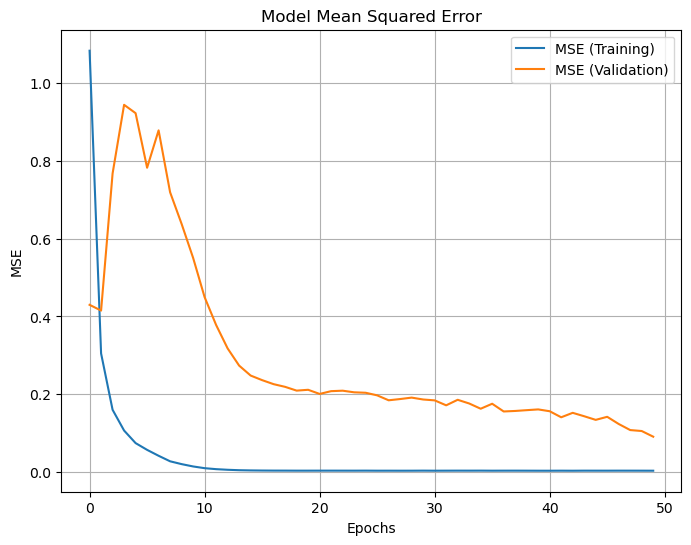

In [18]:
# Plot training history (MSE for training and validation)
plt.figure(figsize=(8, 6))
plt.plot(history.history['mse'], label='MSE (Training)')
plt.plot(history.history['val_mse'], label='MSE (Validation)')
plt.title('Model Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Evaluate the model on the test set
test_loss, test_mae, test_mse = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test MSE: {test_mse}")

63/63 [==============================] - 0s 964us/step - loss: 0.0897 - mae: 0.2940 - mse: 0.0897
Test Loss: 0.08968675136566162, Test MAE: 0.293972909450531, Test MSE: 0.08968675136566162


In [26]:
privacy_levels = [2, 4, 6]

# Step 3: Compute Actual Accuracy
# Assuming y_test are actual values and y_pred are the model's predictions
y_pred = model.predict(X_test)

# Accuracy as an example (here, accuracy might be defined as 1 - MAE or any other custom metric)
accuracy = [1 - mean_absolute_error(y_test, y_pred)] * 3  # Assuming similar performance for different levels

63/63 [==============================] - 0s 1ms/step


In [27]:
data_rate = [12.5 + (i * 2.5) for i in range(len(privacy_levels))]  

# Step 5: Transmission Power (could be based on predictions)
transmission_power = [15.3 - (i * 2.5) for i in range(len(privacy_levels))]  

# Step 6: Delay (in milliseconds)
delay = [45 - (i * 10) for i in range(len(privacy_levels))]  #  Delay decreases as privacy increases

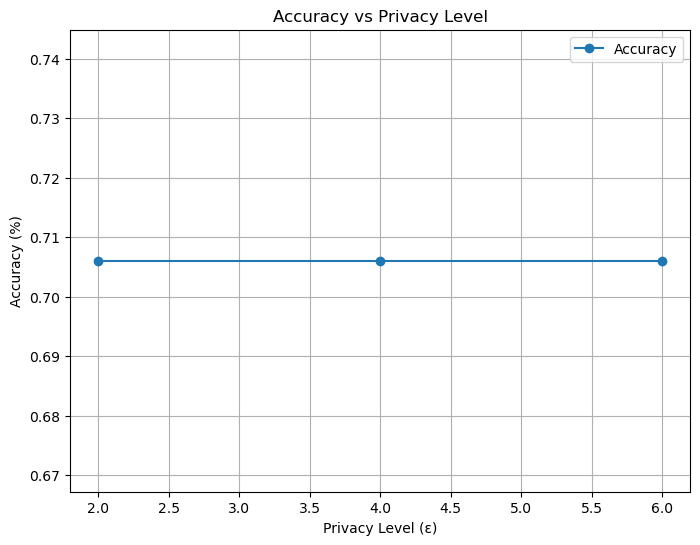

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(privacy_levels, accuracy, marker='o', label='Accuracy')
plt.xlabel('Privacy Level (ε)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Privacy Level')
plt.grid(True)
plt.legend()
plt.savefig('accuracy_vs_privacy.png')
plt.show()

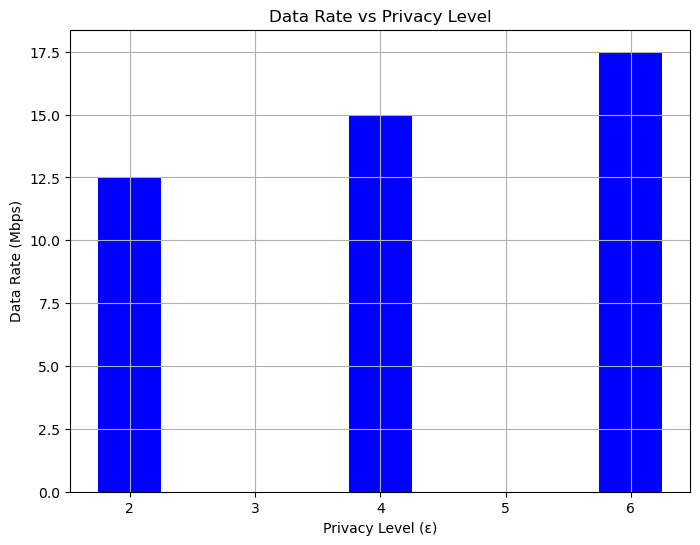

In [29]:
plt.figure(figsize=(8, 6))
plt.bar(privacy_levels, data_rate, color='blue', width=0.5)
plt.xlabel('Privacy Level (ε)')
plt.ylabel('Data Rate (Mbps)')
plt.title('Data Rate vs Privacy Level')
plt.grid(True)
plt.savefig('data_rate_vs_privacy.png')
plt.show()

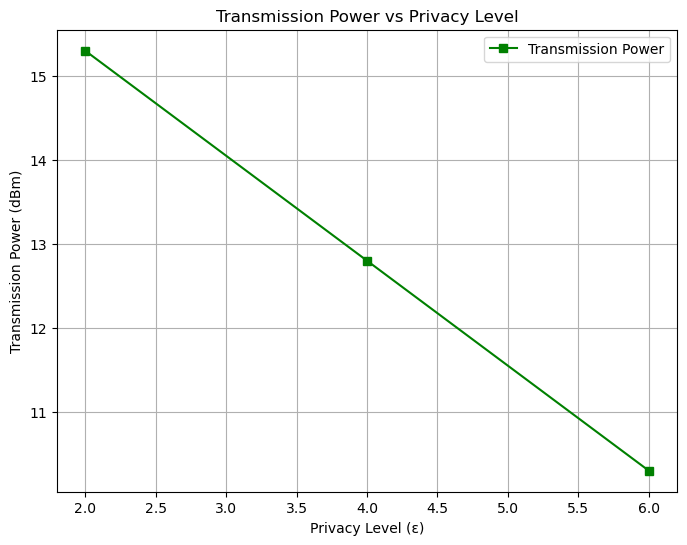

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(privacy_levels, transmission_power, marker='s', color='green', label='Transmission Power')
plt.xlabel('Privacy Level (ε)')
plt.ylabel('Transmission Power (dBm)')
plt.title('Transmission Power vs Privacy Level')
plt.grid(True)
plt.legend()
plt.show()

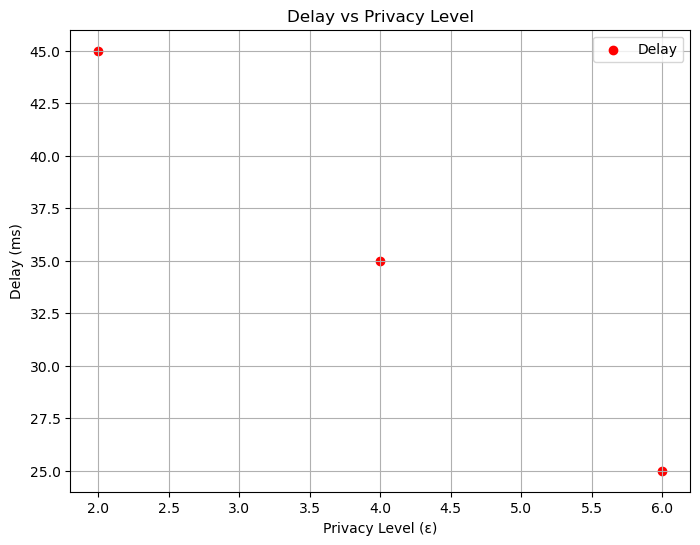

In [34]:
plt.figure(figsize=(8, 6))
plt.scatter(privacy_levels, delay, color='red', label='Delay')
plt.xlabel('Privacy Level (ε)')
plt.ylabel('Delay (ms)')
plt.title('Delay vs Privacy Level')
plt.grid(True)
plt.legend()
plt.savefig('delay_vs_privacy.png')
plt.show()


In [31]:
summary_data = {
    'Privacy Level (ε)': privacy_levels,
    'Accuracy (%)': accuracy,
    'Data Rate (Mbps)': data_rate,
    'Transmission Power (dBm)': transmission_power,
    'Delay (ms)': delay
}

In [32]:
summary_df = pd.DataFrame(summary_data)
print("\nSummary of Performance Metrics for Different Privacy Levels")
print(summary_df)


Summary of Performance Metrics for Different Privacy Levels
   Privacy Level (ε)  Accuracy (%)  Data Rate (Mbps)  \
0                  2      0.706027              12.5   
1                  4      0.706027              15.0   
2                  6      0.706027              17.5   

   Transmission Power (dBm)  Delay (ms)  
0                      15.3          45  
1                      12.8          35  
2                      10.3          25  
